# Lab 8: Graphical Models

The goal of this lab session is to code two methods to estimate the structure of undirected gaussian graphical models and compare them.

You have to send the filled notebook named **"L8_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com before December 12, 2019 at 23:59 and put **"AML-L8"** as subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import sklearn
%matplotlib inline
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## Graphical Models

A graphical model is a probabilistic model for which a graph expresses the conditional dependence structure between random variables. The variables are represented by nodes and the relations between them are represented by edges.

### GLasso

Graphical Lasso is the name of the optimization problem that estimates the precision matrix of a multivariate gaussian and its name comes from the direct link with graphical models and the regularization term. 

Fill in the following class that implements the GLasso algorithm optimized by ADMM:

In [90]:
class my_GLasso():
    
    def __init__(self, alpha, mu, max_iter = 60, tol=1e-5):
        '''
        Parameters:
        alpha : float
            Penalization parameter selected.
        mu: float>0

        Attributes:
        
        covariance_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.
        precision_ : numpy.ndarray, shape (n_features, n_features)
            Estimated precision matrix (inverse covariance).
        '''
        self.covariance_ = None
        self.precision_ = None
        self.graph_structure_ = None

        self.alpha_ = alpha
        self.mu_ = mu
        self.iter_max_ = max_iter
        self.tol_ = tol
        
        self.history_ = None
        
    def update_precision_(self, S, Z, V, mu):
        """
        Performs an update of the precision matrix P
        
        Arguments:
        ----------
        S: (n_features, n_features) numpy.ndarray
            Empirical covariance matrix
        
        Z: (n_features, n_features) numpy.ndarray
            Dual variable for precision matrix
        
        V: (n_features, n_features) numpy.ndarray
            Duality jump
        
        mu: float > 0
            
        Returns:
        --------
        P: (n_features, n_features) numpy.ndarray
            The precision matrix minimizing the gradient of Lagragian wrt P
        """
        T = Z - V - (1/mu)*S
        eig_values, eig_vectors = np.linalg.eig(T)
        new_eig_values = (eig_values + np.sqrt(eig_values**2 + 4/mu))/2
        return eig_vectors.T @ np.diag(new_eig_values) @ eig_vectors
    
    def update_dual_(self, P, S, V, alpha, mu):
        """
        Performs an update of the precision matrix dual Z
        
        Arguments:
        ----------
        S: (n_features, n_features) numpy.ndarray
            Empirical covariance matrix
        
        P: (n_features, n_features) numpy.ndarray
            Precision matrix estimate
        
        V: (n_features, n_features) numpy.ndarray
            Duality jump
        
        alpha: float > 0
            Regularization parameter
        
        mu: float > 0
            
        Returns:
        --------
        Z: (n_features, n_features) numpy.ndarray
            The dual precision matrix minimizing the gradient of Lagragian wrt Z
        """
        return np.multiply(np.sign(P+V), np.maximum(0, np.absolute(P + V) - alpha/mu))
    
    def update_jump_(self, old_V, P, Z, mu):
        """
        Updates the duality jump V
        
        Arguments:
        ----------
        old_V: (n_features, n_features) numpy.ndarray
            Old duality jump
        
        P: (n_features, n_features) numpy.ndarray
            Precision matrix estimate
            
        Z: (n_features, n_features) numpy.ndarray
            Dual variable for precision matrix
        
        mu: float > 0
        
        Returns:
        --------
        (n_features, n_features) numpy.ndarray
            New value for the duality jump
        """
        return old_V + mu*(P-Z)
        
    def fit(self, X):
        """ Fits the GraphicalLasso model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        n_samples, n_features = X.shape
        
        # Compute empirical estimators for esperance and covariance
        esperance = np.mean(X, axis=0)
        
        # TODO - optimize this calculation
        S = np.zeros((n_features, n_features))
        for i in range(n_samples):
            dev = (X[i] - esperance).reshape(-1,1)
            S += dev@dev.T
        S /= (2*n_samples)
        
        # Initialize latent variable to definite positive symetric matrices
        Zn = np.eye(n_features)
        Vn = np.eye(n_features)
        Pn = np.eye(n_features)
        
        self.history_ = {
            "precision": [Pn],
            "dual": [Zn],
            "jump": [Vn],
        }
                
        converged = False
        itr = 0
        
        while itr < self.iter_max_ and not converged:
            
            Pnp1 = self.update_precision_(S, Zn, Vn, self.mu_)
            Znp1 = self.update_dual_(Pnp1, S, Vn, self.alpha_, self.mu_)
            Vnp1 = self.update_jump_(Vn, Pnp1, Znp1, self.mu_)
            
            converged = np.linalg.norm(Pn - Pnp1) < self.tol_ * np.linalg.norm(Pn)
        
            Pn = Pnp1
            Vn = Vnp1
            Zn = Znp1
            
            self.history_["precision"].append(Pn)
            self.history_["dual"].append(Zn)
            self.history_["jump"].append(Vn)
            itr += 1
        
        self.precision_ = self.graph_structure_ = Zn
        self.covariance_ = np.linalg.inv(Zn)
        
        return self        
    
    def get_params(self, deep=True):
        return {
            "alpha": self.alpha_,
            "mu": self.mu_,
            "max_iter": self.iter_max_,
            "tol": self.tol_
        }
    
    def set_params(self, **params):
        if "alpha" in params:
            self.alpha_ = params["alpha"]
        if "mu" in params:
            self.mu_ = params["mu"]
        return self

### Nodewise Regression

Fill in the following class that implements the nodewise regression algorithm to estimate a graphical model structure. You can use `LassoCV` for the regressions. Bonus (not graded): Implement your own cross-validation lasso.

In [23]:
from sklearn.linear_model import LassoCV

class my_nodewise_regression():
    
    def __init__(self, rule, alpha):
        '''
        Parameters:
        
        rule: {"OR", "AND"}
        alpha: float
            regularization parameter
        
        Attributes:
        
        covariance_structure_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.        
        '''
        self.graph_structure_ = None
        self.rule_ = rule
        self.alpha_ = alpha
        
    def fit(self, X):
        """ Fit the model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        n_features = X.shape[1]
        beta = np.zeros((n_features, n_features))
        for j in range(n_features):
            y = X[:, j]#.reshape(-1,1)
            x = np.delete(X, j, axis=1)
            regressor = sklearn.linear_model.Lasso(alpha=self.alpha_)
            regressor.fit(X=x, y=y)
            beta[j, :j], beta[j, j+1:] = regressor.coef_[:j], regressor.coef_[j:]
        
        domain_estimate = beta > 1e-7
        
        if self.rule_ == "OR":
            beta = np.absolute(beta) > 0.
            adj = beta | beta.T
        
        elif self.rule_ == "AND":
            beta = np.absolute(beta) > 0.
            adj = beta & beta.T
        
        self.graph_structure_ =self.precision_ = adj
        return self

Generate an easy-to-check (non-trivial, p<=6) example and plot the 4 (real, GLasso, AND, OR) graphs. You can use `networkx` to plot the resulting graph.

In [91]:
mu=[0., 5., -5.]
cov =np.array([
    [1., 2., 0.],
    [2., 1., 0.],
    [0., 0., 1.]
])
#cov = cov.T@cov

X = np.array([np.random.multivariate_normal(mu, cov) for _ in range(25)])
precision = np.linalg.inv(cov)


C:\Users\sbran\Anaconda3\envs\aml-tp4\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  if __name__ == '__main__':


In [92]:
model_glasso = my_GLasso(alpha=0.4, mu=1)
model_glasso.fit(X)

model_nor = my_nodewise_regression(rule="OR", alpha=1)
model_nor.fit(X)

model_nand = my_nodewise_regression(rule="AND", alpha=1)
model_nand.fit(X)

In [93]:
def draw(model, node_labels=True, edge_labels=True):
    K = model.graph_structure_
    draw_precision(K, node_labels=node_labels, edge_labels=edge_labels)

def draw_precision(K, node_labels=True, edge_labels=True):
    G = nx.Graph()
    G.add_nodes_from(range(K.shape[0]))

    nonzeros = list(zip(*np.nonzero(K), [{"weight": K[nz]} for nz in zip(*np.nonzero(K))]))
    G.add_edges_from(nonzeros)

    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, alpha=0.8)
    nx.draw_networkx_edges(G, pos, label=None, alpha=0.5)
    if node_labels:
        nx.draw_networkx_labels(G, pos)
    if edge_labels:
        edge_labels = {(u, v): "{:.3f}".format(d) for (u,v,d) in G.edges(data="weight") if u != v}
        nx.draw_networkx_edge_labels(G, pos, edge_labels)

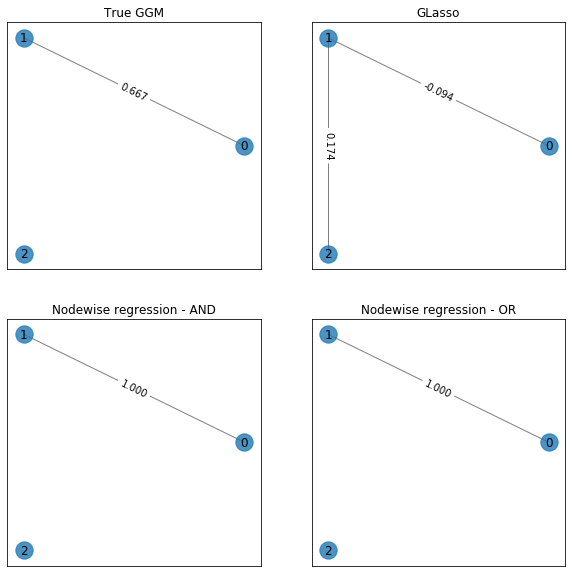

In [94]:
plt.figure(figsize=(10,10))

plt.subplot(221)
draw_precision(precision)
plt.title("True GGM")
plt.subplot(222)
draw(model_glasso)
plt.title("GLasso")
plt.subplot(223)
draw(model_nand)
plt.title("Nodewise regression - AND")
plt.subplot(224)
draw(model_nor)
plt.title("Nodewise regression - OR")
plt.show()

## Simulations

Compare the two graph estimators for the following model with $p = 300$ and $n = 40, 80, 320$:

- An AR(1)-Block model. In this model the *covariance* matrix is block-diagonal with equalsized AR(1)-blocks of the form $(\Sigma_{Block})_{i, j} = 0.9^{|i−j|}$, take $30 \times 30$ blocks.

Report accuracy and F1 score for the edge estimation.

For GLasso estimation, use cross-validation k-fold with loglikelihood loss to select the $\lambda$ penalization parameter.

Measure the estimation error of the GLasso matrix result.

In [95]:
import scipy as scp
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV

### Data generation

In [96]:
nb_blocks = 10
block_size = 30
n = 80

In [97]:
block = [[0.9**(abs(i - j)) for i in range(block_size)] for j in range(block_size)]
cov = scp.linalg.block_diag(*[block]*nb_blocks)
precision = np.linalg.inv(cov)

In [98]:
X = np.array([np.random.multivariate_normal(np.ones((nb_blocks * block_size,)), cov) for _ in range(n)])

### Defining metrics

In [99]:
def edge_f1(model_precision, real_precision):
    assert model_precision.shape[0] == real_precision.shape[0]
    assert model_precision.shape[1] == real_precision.shape[1]
    
    n = model_precision.shape[0]
    triu_indices = np.triu_indices(n)
    
    model_edges = np.absolute(model_precision[triu_indices]) > 1e-7
    real_edges = np.absolute(real_precision[triu_indices]) > 1e-7
    
    acc = accuracy_score(y_true=real_edges, y_pred=model_edges)
    f1 = f1_score(y_true=real_edges, y_pred=model_edges)
    return acc, f1

In [125]:
def normal_log_likelihood(estimator, X, y=None):
    n_samples, n_features = X.shape
    precision = estimator.precision_
    det = np.linalg.det(precision)
    if det < 1e-3:
        det = 1e-3
    elif det > 1e3:
        det = 1e3
    
    esperance = X.mean(axis=0)
    S = np.zeros((n_features, n_features))
    for i in range(n_samples):
        dev = (X[i] - esperance).reshape(-1,1)
        S += dev@dev.T
    S /= n_samples
    
    return np.log(det) - np.trace(S@precision)

### Model training

##### GLasso - Model selection

In [137]:
exploration_space = np.linspace(1e-4, 1, 100)

clf = GridSearchCV(estimator=my_GLasso(alpha=1, mu=[10]), 
                   param_grid={"alpha": exploration_space, "mu": [1]},
                   scoring=normal_log_likelihood, iid=False,
                   cv=3, n_jobs=3)

In [138]:
clf.fit(X)
print("Grid searched best params:", clf.best_params_)
print("Grid searched best score:", clf.best_score_)

Grid searched best params: {'alpha': 0.9697272727272728, 'mu': 1}
Grid searched best score: -42.70266285459676


In [139]:
model_glasso = clf.best_estimator_
model_glasso.fit(X)
model_glasso.get_params()

{'alpha': 0.9697272727272728, 'mu': 1, 'max_iter': 60, 'tol': 1e-05}

##### Nodewise regression

In [140]:
model_nodewise_or = my_nodewise_regression(rule="OR", alpha=1)
model_nodewise_or.fit(X)

model_nodewise_and = my_nodewise_regression(rule="AND", alpha=1)
model_nodewise_and.fit(X)

### Model evaluation

In [141]:
acc, f1 = edge_f1(model_glasso.precision_, precision)
print("--------- GLasso ---------")
print("F1 Score:                    ", f1)
print("Acc. score:                  ", acc)
print("Error (Frobenius):  ", np.linalg.norm(model_glasso.precision_, "fro"))

--------- GLasso ---------
F1 Score:                     0.039265993641586255
Acc. score:                   0.6184939091915836
Error (Frobenius):   87.15595433378978


In [142]:
acc, f1 = edge_f1(model_nodewise_and.precision_, precision)
print("--------- Nodewise AND ---------")
print("F1 Score:                    ", f1)
print("Acc. score:                  ", acc)

--------- Nodewise AND ---------
F1 Score:                     0.08441558441558442
Acc. score:                   0.9875083056478405


In [143]:
acc, f1 = edge_f1(model_nodewise_or.precision_, precision)
print("--------- Nodewise OR ---------")
print("F1 Score:                    ", f1)
print("Acc. score:                  ", acc)

--------- Nodewise OR ---------
F1 Score:                     0.18125960061443933
Acc. score:                   0.9881949058693245
